In [2]:
import math
import numpy as np
import pandas as pd
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score, classification_mean_width_score
import matplotlib.pyplot as plt
import json

from src.model import MockModel
from src.utils import index_for_arange, write_results, cq_filter, cq_labels
import src.plot as plot
from src.eval import (
    adjusted_classification_x_width_score,
    size_stratified_classification_coverage_score,
    cq_stats,
    set_size_equals,
)
from src.heuristics import TopKSelector, HeuristicCutoffSelector, TopKCutoffSelector

In [3]:
# load data
dataset = 'hwu64'
intent_classifier = 'bert'
data_dir = f'data/{dataset}/{intent_classifier}/'

df_train_preds = pd.read_csv(data_dir + "train_predictions.csv")
df_test_preds = pd.read_csv(data_dir + "test_predictions.csv")
df_calibration_preds = pd.read_csv(data_dir + "calibration_predictions.csv")

labels = pd.read_csv(data_dir+'/labels.csv', header=0, names=['index','label'])
labels = list(labels.label)
N_INTENTS = len(labels)
N_INTENTS

68

In [4]:
# check train-calibration-test split sizes
df_train_preds.shape[0], df_calibration_preds.shape[0], df_test_preds.shape[0]

(15429, 5143, 5143)

In [5]:
# apply some basic transformations
df_train = df_train_preds.reset_index().rename(columns={'index': 'utterance'})
df_test = df_test_preds.reset_index().rename(columns={'index': 'utterance'})
df_calibration = df_calibration_preds.reset_index().rename(columns={'index': 'utterance'})

df_train['utterance'] = df_train['utterance'].apply(lambda h: 'train_' + str(h))
df_test['utterance'] = df_test['utterance'].apply(lambda h: 'test_' + str(h))
df_calibration['utterance'] = df_calibration['utterance'].apply(lambda h: 'cal_' + str(h))

df_train['utterance'] = df_train['utterance'].astype(str)
df_test['utterance'] = df_test['utterance'].astype(str)
df_calibration['utterance'] = df_calibration['utterance'].astype(str)

In [6]:
# merge datasets to single frame
fullset = pd.concat([df_test, df_calibration], ignore_index=True)
assert fullset.utterance.value_counts().max() == 1, "Hashes/utterances should be unique in full set"
fullset = fullset.drop(['label', 'hash', 'text'], axis=1)
fullset.head()

,utterance,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,...,label_58,label_59,label_60,label_61,label_62,label_63,label_64,label_65,label_66,label_67
0,test_0,0.000155,0.000080,0.000197,0.000058,0.000062,0.000061,0.000080,0.000063,0.000274,...,0.000157,0.000139,0.000111,0.000135,0.000095,0.000612,0.000084,0.000098,0.000124,0.000235
1,test_1,0.000014,0.000060,0.001370,0.000035,0.000009,0.000058,0.000094,0.001026,0.000889,...,0.000079,0.000663,0.000253,0.000216,0.000069,0.000032,0.000130,0.000120,0.000016,0.000085
2,test_2,0.000334,0.000447,0.000116,0.000655,0.000777,0.000620,0.000398,0.000225,0.000070,...,0.000473,0.000124,0.000395,0.000247,0.000657,0.002894,0.001799,0.000202,0.965851,0.000727
3,test_3,0.000352,0.000045,0.000397,0.000024,0.000065,0.000077,0.000024,0.038772,0.000661,...,0.000102,0.000419,0.001007,0.000610,0.000675,0.000545,0.000670,0.000490,0.000204,0.001312
4,test_4,0.000578,0.002451,0.000949,0.000856,0.000331,0.001254,0.001088,0.001402,0.001279,...,0.000759,0.000523,0.003132,0.001621,0.004104,0.000771,0.000870,0.000443,0.003633,0.000769


In [7]:
# parameters for evaluation
X_train = fullset[['utterance']]
X_calib = df_calibration[['utterance']]
X_test = df_test[['utterance']]

a_start = 0.01
a_stop = .4
a_step = 0.01
alpha = np.arange(a_start, a_stop, a_step)

max_ps_size = math.ceil(N_INTENTS * .25)
max_ps_size = 7

target_alpha = .05
target_index = index_for_arange(a_start, a_step ,target_alpha)

In [8]:
# instantiate a mock sklearn model which simply looks up the results in a lookup table
model = MockModel(fullset, 'utterance', softmax=False)
# fit the test dataset
model.fit(X_test, df_test['label'])
# extract the test targets from the datasets
y_test = df_test['label'].apply(lambda lbl: list(model.classes_).index(lbl))

In [9]:
# marginal conformal prediction
mapie_marginal = MapieClassifier(estimator=model, cv="prefit", method="score", random_state=42)
mapie_marginal.fit(X_calib, df_calibration['label'])
y_pred_marginal, y_ps_marginal = mapie_marginal.predict(X_test, alpha=alpha)


coverages_marginal = [
    classification_coverage_score(y_test, y_ps_marginal[:, :, i])
    for i, _ in enumerate(alpha)
]
cqsize_marginal = [
    adjusted_classification_x_width_score(y_ps_marginal[:, :, i], np.mean,max_ps_size)
    for i, _ in enumerate(alpha)
]
single_marginal = [
    set_size_equals(y_ps_marginal[:,:,i], 1)
    for i, _ in enumerate(alpha)
]
ambiguous_marginal = [
    (y_ps_marginal[:, :, i].sum(axis=1) >= max_ps_size).mean()
    for i, _ in enumerate(alpha)
]
ssc_marginal = [
    size_stratified_classification_coverage_score(y_test, y_ps_marginal[:, :, i])
    for i, _ in enumerate(alpha)
]

results = cq_stats(y_ps_marginal[:, :, target_index], y_test, max_ps_size)
write_results('hwu64-bert-cicc', dataset, intent_classifier, 'cicc', results)
results

/Users/floris/Documents/archive/publications/cicc/cicc/src/eval.py:101: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


(0.9540050672383551,
 0.8201438848920863,
 2.810514786418401,
 0.005638732257437293)

In [10]:
# adaptive conformal prediction
mapie_adaptive = MapieClassifier(estimator=model, cv="prefit", method="cumulated_score", random_state=42)
mapie_adaptive.fit(X_calib, df_calibration['label'])
y_pred_adaptive, y_ps_adaptive = mapie_adaptive.predict(X_test, alpha=alpha)


coverages_adaptive = [
    classification_coverage_score(y_test, y_ps_adaptive[:, :, i])
    for i, _ in enumerate(alpha)
]
cqsize_adaptive = [
    adjusted_classification_x_width_score(y_ps_adaptive[:, :, i], np.mean,max_ps_size)
    for i, _ in enumerate(alpha)
]
single_adaptive = [
    set_size_equals(y_ps_adaptive[:,:,i], 1)
    for i, _ in enumerate(alpha)
]
ambiguous_adaptive = [
    (y_ps_adaptive[:, :, i].sum(axis=1) >= max_ps_size).mean()
    for i, _ in enumerate(alpha)
]
ssc_adaptive = [
    size_stratified_classification_coverage_score(y_test, y_ps_adaptive[:, :, i])
    for i, _ in enumerate(alpha)
]

cq_stats(y_ps_adaptive[:, :, target_index], y_test, max_ps_size)

(0.9753569783509903,
 0.7093136301769395,
 3.2146974063400577,
 0.16216216216216217)

In [11]:
# TOP-K conformal prediction
mapie_topk = MapieClassifier(estimator=model, cv="prefit", method="top_k", random_state=42)
mapie_topk.fit(X_calib, df_calibration['label'])
y_pred_topk, y_ps_topk = mapie_topk.predict(X_test, alpha=alpha)


coverages_topk = [
    classification_coverage_score(y_test, y_ps_topk[:, :, i])
    for i, _ in enumerate(alpha)
]
cqsize_topk = [
    adjusted_classification_x_width_score(y_ps_topk[:, :, i], np.mean,max_ps_size)
    for i, _ in enumerate(alpha)
]
single_topk = [
    set_size_equals(y_ps_topk[:,:,i], 1)
    for i, _ in enumerate(alpha)
]
ambiguous_topk = [
    (y_ps_topk[:, :, i].sum(axis=1) >= max_ps_size).mean()
    for i, _ in enumerate(alpha)
]
ssc_topk = [
    size_stratified_classification_coverage_score(y_test, y_ps_topk[:, :, i])
    for i, _ in enumerate(alpha)
]

cq_stats(y_ps_topk[:, :, target_index], y_test, max_ps_size)

/Users/floris/Documents/archive/publications/cicc/cicc/src/eval.py:101: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


(0.9663620454987362, 0.0, 3.0, 0.0)

In [12]:
# RAPS
mapie_raps = MapieClassifier(estimator=model, cv="prefit", method="raps")
mapie_raps.fit(X_calib, df_calibration['label'])
y_pred_raps, y_ps_raps = mapie_raps.predict(X_test, alpha=alpha)


coverages_raps = [
    classification_coverage_score(y_test, y_ps_raps[:, :, i])
    for i, _ in enumerate(alpha)
]
cqsize_raps = [
    adjusted_classification_x_width_score(y_ps_raps[:, :, i], np.mean,max_ps_size)
    for i, _ in enumerate(alpha)
]
single_raps = [
    set_size_equals(y_ps_raps[:,:,i], 1)
    for i, _ in enumerate(alpha)
]
ambiguous_raps = [
    (y_ps_raps[:, :, i].sum(axis=1) >= max_ps_size).mean()
    for i, _ in enumerate(alpha)
]
ssc_raps = [
    size_stratified_classification_coverage_score(y_test, y_ps_raps[:, :, i])
    for i, _ in enumerate(alpha)
]

cq_stats(y_ps_raps[:, :, target_index], y_test, max_ps_size)

/Users/floris/Documents/archive/publications/cicc/cicc/src/eval.py:101: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


(0.9677231188022555, 0.543651565234299, 3.618236046016191, 0.0)

In [13]:
# heuristic 1: select all classes above a certain cutoff or the top-5 if there are none
topk_cutoff = TopKCutoffSelector(estimator=model, cutoff=1-target_alpha, k=5)
y_ps_h1 = topk_cutoff.predict(X_test)
results_h1 = cq_stats(y_ps_h1, y_test, max_ps_size)
write_results('hwu64-bert-h1', dataset, intent_classifier, 'h1', results_h1)
results_h1

(0.9673342407155356, 0.7003694341823838, 5.0, 0.0)

In [14]:
top_95 = HeuristicCutoffSelector(estimator=model, cutoff=1-target_alpha)
y_ps_h2 = top_95.predict(X_test)
results_h2 = cq_stats(y_ps_h2, y_test, max_ps_size)
write_results('hwu64-bert-h2', dataset, intent_classifier, 'h2', results_h2)
results_h2

/Users/floris/Documents/archive/publications/cicc/cicc/src/eval.py:101: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


(0.9029749173634066, 1.0, nan, 0.0)

In [15]:
topk_5 = TopKSelector(estimator=model, k=5)
y_ps_h3 = topk_5.predict(X_test)

results_h3 = cq_stats(y_ps_h3, y_test, max_ps_size)
write_results('hwu64-bert-h3', dataset, intent_classifier, 'h3', results_h3)
results_h3

(0.9786117052304103, 0.0, 5.0, 0.0)

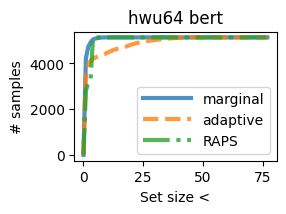

In [16]:
to_plot = [
    (y_ps_marginal, 'marginal', '-', None),
    (y_ps_adaptive, 'adaptive', '--', None),
    (y_ps_raps, 'RAPS', '-.', None),
    # (y_ps_topkmapie, 'TOPK', ':', None),
    # (y_ps_top_5_95, 'heuristic a', 'dashed', 'black'),
    # (y_ps_top_95,  'heuristic b', 'dotted', 'black'),
    # (y_ps_topk_5,  'heuristic c', '-.', 'black'),
]
fig, ax = plt.subplots(1, 1, figsize=plot.fig_dim_1)
for (resultset, label, style, color) in to_plot:
    if len(label) > len('heuristic') and label[:len('heuristic')] == 'heuristic':
        to_plot_result = resultset
    else:
        to_plot_result = resultset[:, :, target_index]
    ax.plot(
        np.cumsum([set_size_equals(to_plot_result, i) for i in range(78)]),
        label=label,
        linestyle=style,
        color=color,
        linewidth=3,
        alpha=.8)
    # ax.set_xscale('log')
plt.xlabel('Set size <')
plt.ylabel('# samples')
plt.title(f'{dataset} {intent_classifier}'.format(target_alpha))
plt.legend(handlelength=3.5)
plt.tight_layout()
plt.savefig(f'results/cum_set_size_{dataset}_{intent_classifier}.png', dpi=1200)

In [17]:
y_ps_which = y_ps_marginal
ambiguous_indices = np.where((y_ps_which[:, :, target_index].sum(axis=1) >= max_ps_size))
ambiguous = df_test.loc[ambiguous_indices]
list(zip(ambiguous.index,[ labels[l] for l in ambiguous.label.tolist()], ambiguous.text.tolist()))

[(70, 'recommendation_events', 'olly'),
 (91, 'music_likeness', 'this song is too good'),
 (227, 'general_quirky', 'do i have to go to the gym'),
 (258, 'audio_volume_mute', 'silently adjust'),
 (474, 'general_quirky', 'how many times does it go'),
 (645, 'news_query', 'sports head lines please'),
 (721, 'play_audiobook', 'read that back'),
 (848,
  'music_dislikeness',
  "i don't want to hear any more songs of that type"),
 (1106, 'general_quirky', 'check celebrity wiki'),
 (1787, 'lists_query', 'Get all availables'),
 (1852, 'music_likeness', 'rating'),
 (1924, 'transport_query', 'take me to mc donalds'),
 (2137, 'qa_factoid', 'search'),
 (2139, 'audio_volume_up', 'unmute'),
 (2188, 'audio_volume_mute', 'please unmute yourself'),
 (2348, 'datetime_query', "what's the best day next week to go out for pizza"),
 (2397, 'general_quirky', 'i need a manger'),
 (2810, 'play_music', 'assistant shuffle entire library'),
 (2968, 'iot_hue_lighton', 'put the disco lights on'),
 (3064, 'general_g

In [18]:
for a in ambiguous.index:
    alternatives = np.where(y_ps_which[a, :, target_index])[0]
    print(" & ".join([ambiguous.loc[a].text, labels[ambiguous.loc[a].label].replace("_", " "), ', '.join([labels[l].replace("_", " ") for l in alternatives])]) + " \\\\")

olly & recommendation events & calendar set, general quirky, lists createoradd, music likeness, music query, play game, play music, play radio \\
this song is too good & music likeness & audio volume mute, general affirm, general commandstop, general joke, general negate, lists remove, music dislikeness, music likeness \\
do i have to go to the gym & general quirky & calendar query, general quirky, lists query, recommendation events, recommendation locations, transport traffic, weather query \\
silently adjust & audio volume mute & audio volume down, audio volume other, audio volume up, iot hue lightchange, iot hue lightdim, iot hue lightup, music settings \\
how many times does it go & general quirky & datetime query, general quirky, lists query, qa factoid, qa maths, transport query, transport traffic \\
sports head lines please & news query & calendar set, general quirky, iot hue lightchange, music likeness, news query, qa factoid, social post, weather query \\
read that back & play

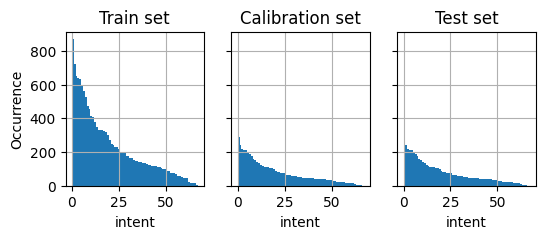

In [19]:
label_sorting_map = {i: x for x, i in enumerate(df_train.label.value_counts(sort=True).index)}
for i in range(len(labels)):
    if i not in label_sorting_map:
        label_sorting_map[i] = len(label_sorting_map)
fig, axs = plt.subplots(1,3,figsize=(plot.fig_width_in * 2, 2), sharey=True)
pd.Series(list(map(lambda x: label_sorting_map[x], df_train.label, ))).hist(bins=N_INTENTS, ax=axs[0])
pd.Series(list(map(lambda x: label_sorting_map[x], df_calibration.label, ))).hist(bins=N_INTENTS, ax=axs[1])
pd.Series(list(map(lambda x: label_sorting_map[x], df_test.label, ))).hist(bins=N_INTENTS, ax=axs[2])
titles = ['Train set', 'Calibration set', 'Test set']
[ax.set_xlabel('intent') for ax in axs]
[ax.set_title(title) for (ax, title) in zip(axs, titles)]
axs[0].set_ylabel('Occurrence')
# plt.yticks([]) 
plt.savefig(f"results/label_distribution_{dataset}.png", dpi=1200)
plt.show()

In [20]:
cq_inputs = df_test[cq_filter(y_ps_marginal[:, :, target_index], max_ps_size)].text
cq_lbls = cq_labels(y_ps_marginal[:, :, target_index], max_ps_size, labels)

cqs = []
for i, (text, lbls) in enumerate(zip(cq_inputs, cq_lbls)):
    cqs.append({
        "id": i,
        "text": text,
        "predictions": lbls,
    })

with open(f'results/clarification_questions_{dataset}_{intent_classifier}.json', 'w') as f:
    json.dump(cqs, f, indent=4)

In [23]:
pd.Series(np.cumsum([set_size_equals(y_ps_marginal[:, :, target_index], i) for i in range(N_INTENTS+1)])).to_csv(f'results/cum_{dataset}_{intent_classifier}.csv')